In [19]:
import keras

In [20]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12853393581756864524
]


In [21]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import string
from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout
from keras.models import Model
from string import punctuation

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [22]:
def clean_str(tweet):
    """
    Cleaning of dataset
    """
    tweet = re.sub(r"\\", "", tweet)    
    tweet = re.sub(r"\'", "", tweet)    
    tweet = re.sub(r"\"", "", tweet)
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = re.sub(r'˜¥\w*','', tweet)
    tweet = re.sub(r'˜€\w*','', tweet)
    tweet = re.sub(r'˜¤\w*','', tweet)
    tweet = re.sub(r'˜ªðÿ\w*','', tweet)
    tweet = re.sub(r'ðÿ™\w*','', tweet)
    tweet = re.sub(r'\\\w*','', tweet)
    tweet = re.sub(r'±\w*','', tweet)
    tweet = re.sub(r'\w*','', tweet)
    tweet = re.sub(r'™„˜­\w*','', tweet)
    tweet = re.sub(r'ðÿ§€\w*','', tweet)
    tweet = re.sub(r'‘šðÿ¼\w*','', tweet)
    tweet = re.sub(r'ðÿ•\w*','', tweet)
    tweet = re.sub(r'€¢\w*','', tweet)
    tweet = re.sub(r'ã©\w*','', tweet) 
    tweet = re.sub(r'\w*','',tweet)
    #tweet = re.sub(r'ðŸ\x8\w','',tweet)
    return tweet.strip().lower()

In [23]:
data_train = pd.read_excel(r'C:\Users\kushal\Desktop\bennet dataset\Task 2 data\EI-oc-En-train\EI-oc-En-train-joy.xlsx')
#data_train.head()
data_train["label"] = data_train["Intensity Class"].apply(lambda x : x.split(":")[0])
data_train = data_train["Tweet"].apply(clean_str)
data_train.head()

0    quite saddened dates joyous anticipation atten...
1                    days until and days until excited
2    positive research shows salespeople who score ...
3    the birds chirp and the cows moo need listen t...
4            howling with laughter €œwell done bezza €
Name: Tweet, dtype: object

In [24]:
# Input Data preprocessing
data_train = pd.read_excel(r'C:\Users\kushal\Desktop\bennet dataset\Task 2 data\EI-oc-En-train\EI-oc-En-train-joy.xlsx')

data_train["label"] = data_train["Intensity Class"].apply(lambda x : x.split(":")[0])
data_train["Text"] = data_train["Tweet"].apply(clean_str)
#data_train['label'] = data_train['label'].replace('FAKE',1)
#data_train['label'] = data_train['label'].replace('REAL',0)
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.Text.shape[0]):
    #text1 = data_train.Tweet[i]
    text2 = data_train.Text[i]
    #text = str(text1) +""+ str(text2)
    texts.append(text2)
    labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Index(['ID', 'Tweet', 'Affect Dimension', 'Intensity Class', 'label', 'Text'], dtype='object')
What the raw input data looks like:
              ID                                              Tweet  \
0  2017-En-30793  @david_garrett Quite saddened.....no US dates,...   
1  2017-En-30070  2 days until #GoPackGo and 23 days until #GoGi...   
2  2017-En-30692  Positive #psychology research shows salespeopl...   
3  2017-En-31323  As the birds chirp and the cows moo we need to...   
4  2017-En-31553  Howling with laughter at â€œWELL DONE BEZZA!â€...   

  Affect Dimension                        Intensity Class label  \
0              joy              0: no joy can be inferred     0   
1              joy  3: high amount of joy can be inferred     3   
2              joy              0: no joy can be inferred     0   
3              joy   1: low amount of joy can be inferred     1   
4              joy  3: high amount of joy can be inferred     3   

                                       

In [25]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 0)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1616, 1000)
Shape of label tensor: (1616, 4)


In [26]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 1292 162 162
real & fake news in train,valt,test:
[445. 277. 263. 307.]
[44. 43. 47. 28.]
[59. 43. 36. 24.]


In [27]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU

%matplotlib inline

In [28]:
#Using Pre-trained word embeddings
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, r'C:\Users\kushal\Desktop\bennet dataset\glove6b100dtxt\glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


Total 400000 word vectors in Glove.


In [29]:
embedding_vecor_length = 32
modell = Sequential()
modell.add(embedding_layer)
modell.add(Dropout(0.2))
modell.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modell.add(BatchNormalization())
modell.add(Dense(256, activation='relu'))
modell.add(Dense(128, activation='relu'))
modell.add(Dense(64, activation='relu'))
modell.add(Dense(4, activation='softmax'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
modell.fit(x_train, y_train, epochs=10, batch_size=64)

modell.save('lstm.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         433000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 64)           6208      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
__________

In [16]:
embedding_vecor_length = 32
modelg = Sequential()
modelg.add(embedding_layer)
modelg.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
###
modelg.add(BatchNormalization())
###
modelg.add(Dense(4, activation='softmax'))
modelg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelg.summary())
modelg.fit(x_train, y_train, epochs=2, batch_size=64)
modelg.save('gru.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         496600    
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 404       
Total params: 557,704
Trainable params: 557,504
Non-trainable params: 200
_________________________________________________________________
None
Epoch 1/2
1801/1801 [==============================] - 44s 25ms/step - loss: 0.6058 - acc: 0.7367
Epoch 2/2
1801/1801 [==============================] - 49s 27ms/step - loss: 0.4316 - acc: 0.8251


Correct predictions: 105.0
Total number of test examples: 162
Accuracy of model1:  0.6481481481481481


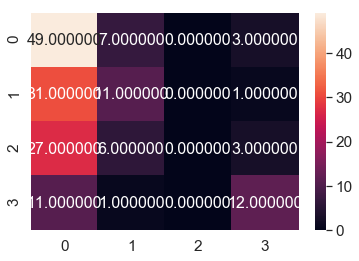

In [30]:
# Test model 1
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = modell.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = modell.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
# plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
# plt.title('Confusion matrix - model1')
# plt.colorbar()
# plt.ylabel('expected label')
# plt.xlabel('predicted label')
# plt.show()
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size


Correct predictions: 72.0
Total number of test examples: 162
Accuracy of model2:  0.4444444444444444


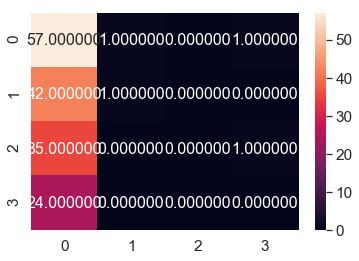

In [31]:
# Test model 2
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = modelg.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = modelg.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
# plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
# plt.title('Confusion matrix - model1')
# plt.colorbar()
# plt.ylabel('expected label')
# plt.xlabel('predicted label')
# plt.show()
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='f')# font size
